In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import plot_model

from sklearn.model_selection import train_test_split

import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2

In [2]:
def prepare_data(mode):
    """ divides data into images and labels
        Min-Max scales images
    Params:
        mode : String (either "padded" or "resized")
    Returns:
        scaled_X : array with images
        y : array with corresponding labels
        (0 for non-IDC, 1 for IDC)
    """
    patches = glob.glob('./' + mode + '/*.png', recursive=True)
    class0 = []
    class1 = []
    for name in glob.glob('./' + mode + '/*class0.png', recursive=True):
        class0.append(name)
    for name in glob.glob('./' + mode + '/*class1.png', recursive=True):
        class1.append(name)
    X = []
    y = []
    for img_name in patches:
        image = cv2.imread(img_name)
        X.append(image)
        y.append(0) if img_name in class0 else y.append(1)
    scaled_X = np.array(X)/255.0
    return scaled_X, y

In [3]:
X_pad, y = prepare_data("padded")

In [4]:
X_pad_train, X_pad_test, y_pad_train, y_pad_test = train_test_split(X_pad, y, test_size=0.1, random_state=42)

In [5]:
y_pad_train_onehot = np_utils.to_categorical(y_pad_train, 2)
y_pad_test_onehot = np_utils.to_categorical(y_pad_test, 2)

In [3]:
def create_CNN():
    input_shape = (50, 50, 3)
    num_classes = 2
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same',activation='relu', input_shape=input_shape)) # strides=(1, 1) default
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [4]:
epochs = 10
batch_size = 128

cnn_pad = create_CNN()
cnn_pad.summary()
plot_model(cnn_pad, to_file='simple_cnn_model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
__________

In [20]:
pad_fit = cnn_pad.fit(X_pad_train, y_pad_train_onehot,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/10
9000/9000 [==============================] - 85s 9ms/step - loss: 0.3967 - acc: 0.8567
Epoch 2/10
9000/9000 [==============================] - 90s 10ms/step - loss: 0.3233 - acc: 0.8659
Epoch 3/10
9000/9000 [==============================] - 92s 10ms/step - loss: 0.2659 - acc: 0.8922
Epoch 4/10
9000/9000 [==============================] - 86s 10ms/step - loss: 0.2500 - acc: 0.8984
Epoch 5/10
9000/9000 [==============================] - 82s 9ms/step - loss: 0.2402 - acc: 0.9044
Epoch 6/10
9000/9000 [==============================] - 81s 9ms/step - loss: 0.2348 - acc: 0.9091
Epoch 7/10
9000/9000 [==============================] - 81s 9ms/step - loss: 0.2174 - acc: 0.9170
Epoch 8/10
9000/9000 [==============================] - 88s 10ms/step - loss: 0.2151 - acc: 0.9166
Epoch 9/10
9000/9000 [==============================] - 96s 11ms/step - loss: 0.2188 - acc: 0.9151
Epoch 10/10
9000/9000 [==============================] - 90s 10ms/step - loss: 0.2044 - acc: 0.9226


Test accuracy: 0.908


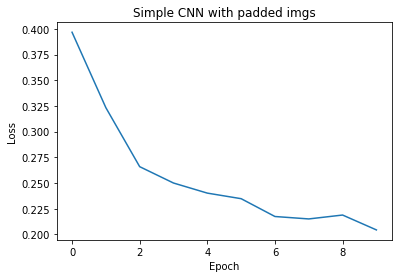

In [21]:
score_pad = cnn_pad.evaluate(X_pad_test, y_pad_test_onehot, verbose=0)
print('Test accuracy:', score_pad[1])

plt.plot(pad_fit.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Simple CNN with padded imgs')
plt.show()

In [ ]:
# for comparison with resized imgs
X_inter, _ = prepare_data("resized")
X_inter_train, X_inter_test, y_inter_train, y_inter_test = train_test_split(X_inter, y, test_size=0.1, random_state=42)
y_inter_train_onehot = np_utils.to_categorical(y_inter_train, 2)
y_inter_test_onehot = np_utils.to_categorical(y_inter_test, 2)

cnn_inter = create_CNN()
inter_fit = cnn_inter.fit(X_inter_train, y_inter_train_onehot,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

In [ ]:
score_inter = cnn_inter.evaluate(X_inter_test, y_inter_test_onehot, verbose=0)
print('Test accuracy:', score_inter[1])

plt.plot(inter_fit.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Simple CNN with interpolated imgs')
plt.show()